## Packages

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import keras
import sys
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(f"Python version -> {sys.version}")  # 3.12.3
print(f"keras version -> {keras.__version__}")  # 3.12.0
print(f"numpy version -> {np.__version__}")  # 2.3.2
print(f"pandas version -> {pd.__version__}")  # 2.3.2

2025-11-24 11:25:30.665860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 11:25:30.713923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 11:25:31.856386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Python version -> 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
keras version -> 3.12.0
numpy version -> 2.3.2
pandas version -> 2.3.2


## Generate a random walk

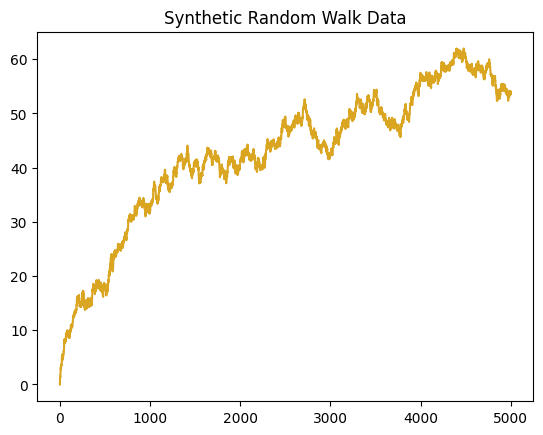

In [2]:
# generate a random walk
def random_walk(steps, scale=1):
    w = np.zeros(steps)
    for x in range(1, steps):
        w[x] = w[x - 1] + scale * np.random.normal()
    return w


time_steps = 5000
data = pd.DataFrame(
    {
        "x": range(time_steps),
        "y": np.arange(time_steps) ** (1 / 2) + random_walk(time_steps),
    }
)
data = data.assign(z=np.log(data.x + 1) + 0.3 * data.y)
data_mat = np.array(data)

plt.plot(data_mat[:, 0], data_mat[:, 2], c="goldenrod")
plt.title("Synthetic Random Walk Data")
plt.show()

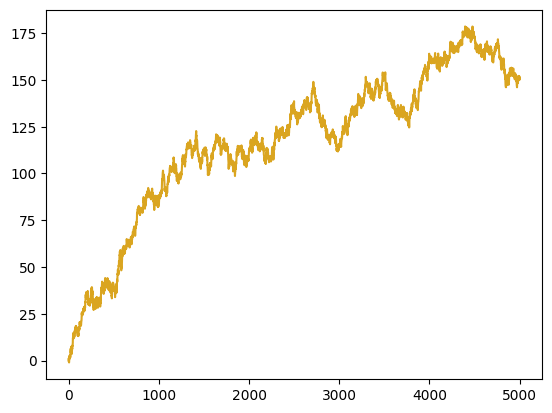

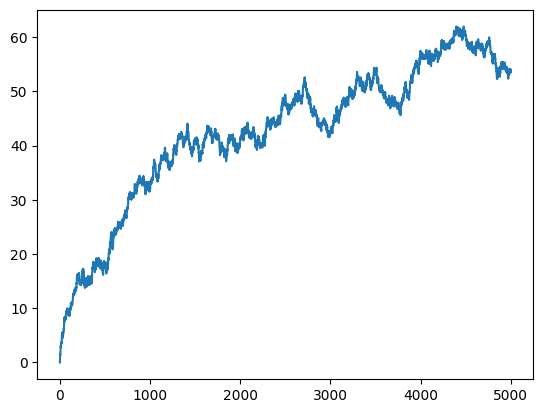

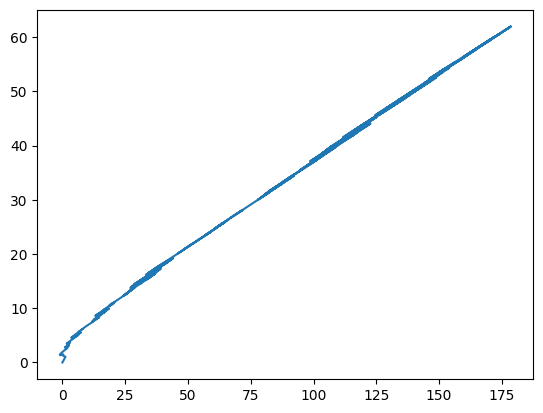

In [ ]:
plt.plot(data_mat[:, 0], data_mat[:, 1], c="goldenrod")
plt.show()
plt.plot(data_mat[:, 0], data_mat[:, 2])
plt.show()
plt.plot(data_mat[:, 1], data_mat[:, 2])

## Splitting Data, and put them in the right format for an RNN

In [5]:
# sliding time windows samples
samples = list()
target = list()
length = 50

# step over the 5,000 in jumps of length
for i in range(time_steps - length):
    # grab from i to i + length
    sample = data_mat[i : i + length, :2]
    outcome = data_mat[i + length, 2]
    target.append(outcome)
    samples.append(sample)

# split out a test set
test_size = 1000
x_test_mat = np.dstack(samples[-test_size:])
x_test_3d_final = np.moveaxis(x_test_mat, [0, 1, 2], [1, 2, 0])

In [6]:
# The RNN needs data with the format of [samples, time steps, features].
# Here, we have N samples, 50 time steps per sample, and 2 features
data_mat_stacked = np.dstack(samples[:-test_size])
data_mat_3d_final = np.moveaxis(data_mat_stacked, [0, 1, 2], [1, 2, 0])

# and fix up the target
target_arr = np.array(target[:-test_size])

## Build the RNN model

In [7]:
model = Sequential()
model.add(
    SimpleRNN(
        128,
        input_shape=(data_mat_3d_final.shape[1], data_mat_3d_final.shape[2]),
        activation="relu",
    )
)
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="linear"))

2025-11-24 11:25:32.889496: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/trappler/code/UP3_sandbox/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# monitor validation progress
early = EarlyStopping(monitor="val_loss", mode="min", patience=7)
callbacks_list = [early]

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [12]:
# and train the model
history = model.fit(
    data_mat_3d_final,
    target_arr,
    epochs=100,
    batch_size=25,
    verbose=1,
    validation_split=0.20,
    callbacks=callbacks_list,
)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 49.5889 - mse: 49.5889 - val_loss: 19.5573 - val_mse: 19.5573
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 48.5022 - mse: 48.5022 - val_loss: 42.3677 - val_mse: 42.3677
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 48.8152 - mse: 48.8152 - val_loss: 16.2937 - val_mse: 16.2937
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.4947 - mse: 46.4947 - val_loss: 17.7701 - val_mse: 17.7701
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 50.3888 - mse: 50.3888 - val_loss: 28.3625 - val_mse: 28.3625
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.2462 - mse: 46.2462 - val_loss: 36.9771 - val_mse: 36.9771
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.1769 - mse: 46.1769 - val_loss: 6.0099 - val_mse: 6.0099


## Some analysis

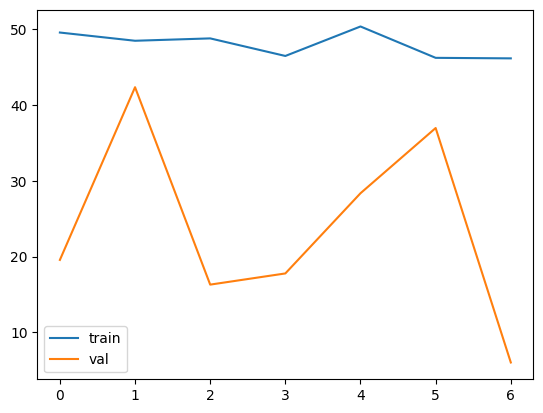

In [13]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


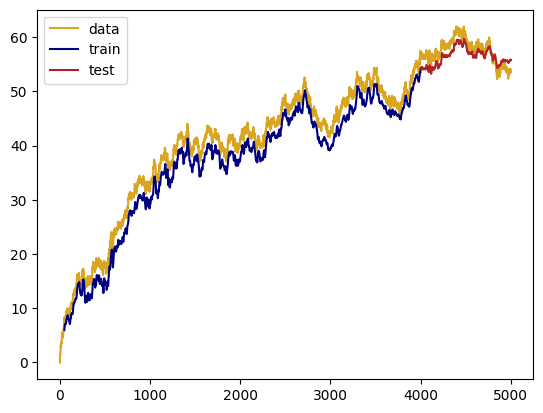

In [14]:
# get predictions
train_predictions = model.predict(data_mat_3d_final)
test_predictions = model.predict(x_test_3d_final)

# plot predictions vs actual
plt.plot(data["x"], data["z"], c="goldenrod", label="data")
plt.plot(
    data.iloc[(length):-test_size]["x"], train_predictions, c="navy", label="train"
)
plt.plot(data.iloc[-test_size:]["x"], test_predictions, c="firebrick", label="test")
plt.legend(loc="best")
plt.show()